#### Case : Isobaric evaporation of liquid hydrogen in a 56 $m^3$ spherical tank experiments.

Este notebook modela el estanque de nueva generación de Air Liquide "SR 57 LH2", el camion de mayor capacidad para transporte de Hidrógeno en Europa. 
El estanque cuenta con una capacidad de 56 m3. Sus dimensiones son: 
Largo: 13,47m
Diametro interno: 2,3m
Diametro externo: 2.5m

Primero, importamos las librerías necesarias para el Notebook

In [1]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

from scipy.integrate import simpson

#### Setup del estanque

Ingresamos los parámetros del modelo, incluyendo las dimensiones del estanque.

In [2]:
# LNG tank properties
d_i = 2.3 # Internal diameter / m
d_o = d_i + 0.02   # External diameter / m
T_air = 298 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.01063 # W/m2/K
U_V = 0.01063 # W/m2/K
eta = 0.95

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 0 # W, 
Q_roof = 0

# Spherical tank volume
V_tank      = 56 # m^3
Lenght_tank = 13.478 # m, length of the tank

# Initial liquid filling / Dimensionless
LF = 0.8

# Specify tank operating pressure
P = 117e3 # Pa

Geo_v1 = "horizontal"

Geo_l1 = "horizontal"

# Initialize large-scale tank
hor_tank = Tank(d_i, d_o, V_tank, Geo_v1, Geo_l1, LF, Lenght_tank)
hor_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b, Q_roof, eta)
# Initialise cryogen
hydrogen1 = Cryogen(name = "hydrogen")
hydrogen1.set_coolprops(P)


# Set cryogen
hor_tank.cryogen = hydrogen1

# Calculate initial evaporation rate
# print("The initial evaporation rate of " + hydrogen1.name + " is %.1e kg/h" % (hor_tank.b_l_dot * 3600))


Calculamos evaporación inicial y tiempo de periodo transiente.

In [3]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen1.name + " is %.1e kg/h" % (hor_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % hor_tank.tau)

# Minimum number of hours to achieve steady state 
tau_h1 = (np.floor(hor_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h1 )

# Calculate boil-off rate
BOR1 = (hor_tank.b_l_dot * 24 * 3600) / (hor_tank.V * hor_tank.LF * hor_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR1 * 100))

The initial evaporation rate of hydrogen is 2.5e+00 kg/h
Transient period = 48059.081 s 
Simulation time: 14 h
BOR = 1.901 %


#### Ejecución

Ejecutamos el modelo

In [4]:
# Define vertical spacing
dz = 0.0075*2

# Calculate number of nodes
n_z = 1 + int(np.round(hor_tank.l_V/dz, 0))

# Define dimensionless computational grid
hor_tank.z_grid = np.linspace(0, 1, n_z)

# Insulated roof
hor_tank.U_roof = 0

# Define evaporation time as twice as the transient period
evap_time = 3600 *tau_h1*2



# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
hor_tank.time_interval = 60

# Time step to plot each vapour temperature profile
hor_tank.plot_interval = evap_time/6

# Simulate the evaporation
hor_tank.evaporate(evap_time)

#### Resultados

#### Perfil de temperatura de la zona vapor

Visualizamos el perfil de temperatura para el vapor, tomando el largo adimensional. 

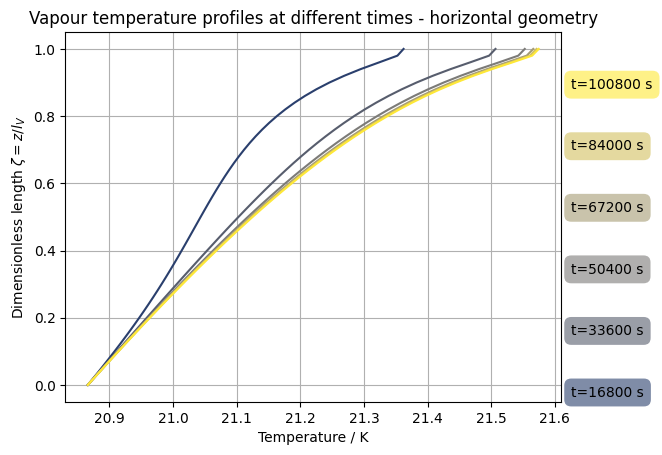

In [5]:
# Visualise the plot
hor_tank.plot_tv()

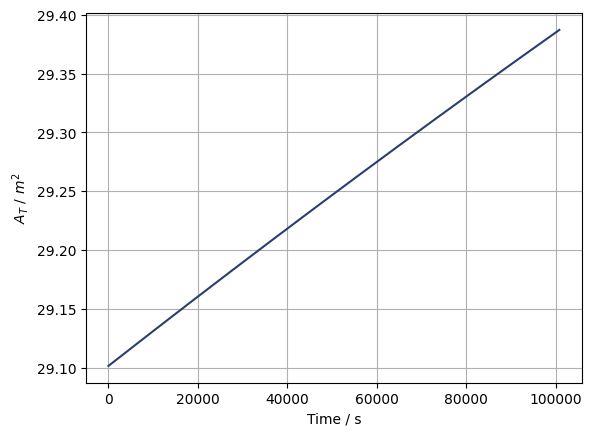

In [6]:
hor_tank.plot_A_T()

/home/javier_corbella/proyectos/Horizontal/CryoEvap/notebooks/../cryoevap/storage_tanks/plots.py:258: RuntimeWarning: divide by zero encountered in divide
  v_z = tank.v_z*(height/zed)*(2*tank.d_i/2 - height)/(2*tank.d_i/2 - zed)
/home/javier_corbella/proyectos/Horizontal/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/javier_corbella/proyectos/Horizontal/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


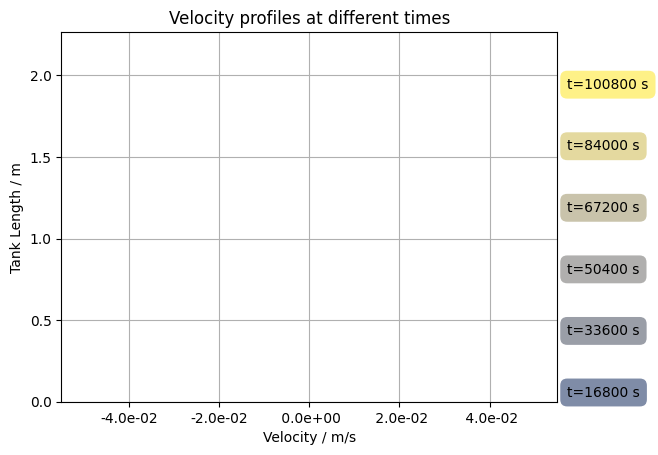

In [7]:
hor_tank.plot_vz()

Visualización de ingresos de calor, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

Ademas, se presenta el calor traspasado desde el vapor hacia el líquido por conducción, $\dot{Q}_{VL}$, y el calor total que ingresa al sistema, $\dot{Q}_{\text{V,w}}$

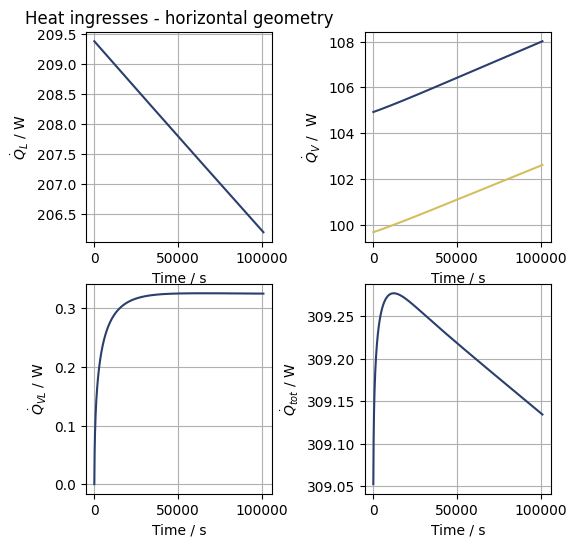

In [8]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
hor_tank.plot_Q(unit="W")

#### Volumen del líquido

Se presenta el volumen del líquido a lo largo del tiempo. Vemos que como hay evaporación, el volumen disminuye.

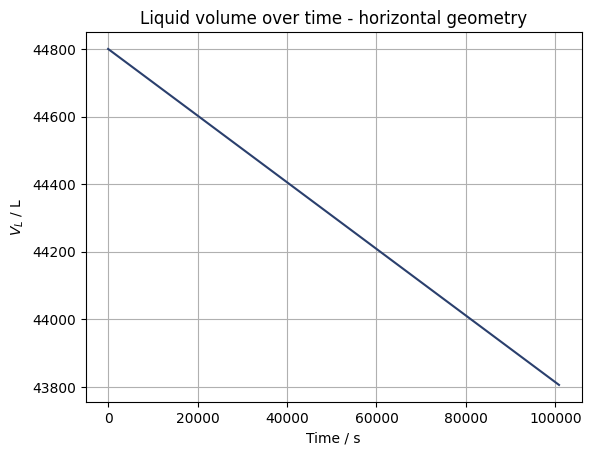

In [9]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
hor_tank.plot_V_L(unit="L")

#### Evaporation rate y BOG

Por último, se presenta la tasa de evaporación y el BOG a lo largo del tiempo.

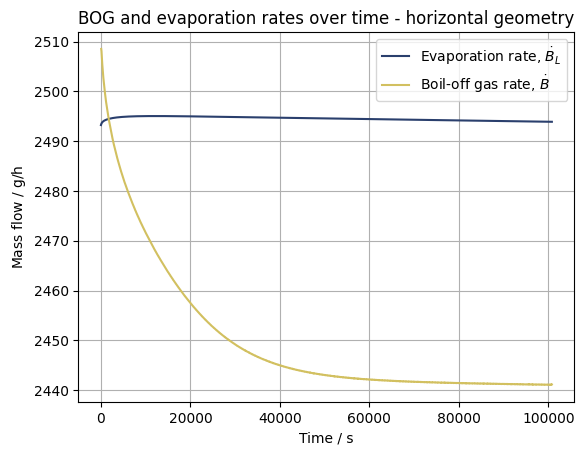

In [10]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
hor_tank.plot_BOG(unit='g/h')

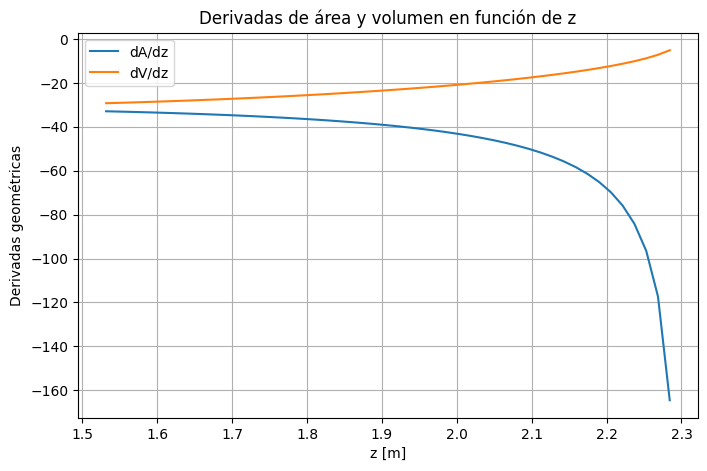

In [11]:
plt.figure(figsize=(8,5))
plt.plot(hor_tank.z_local, hor_tank.dA_dz, label='dA/dz')
plt.plot(hor_tank.z_local, hor_tank.dV_dz, label='dV/dz')
plt.xlabel('z [m]')
plt.ylabel('Derivadas geométricas')
plt.legend()
plt.grid(True)
plt.title('Derivadas de área y volumen en función de z')
plt.show()